# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [2]:
# Load the libraries as required.
import pandas as pd
import numpy as np
import pickle
import shap
import matplotlib.pyplot as plt

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv("../../05_src/data/fires/forestfires.csv", header = 0, names = columns))
fires_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [4]:
X = fires_dt.drop("area", axis=1)

In [5]:
y = fires_dt["area"]

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Define preprocessor 1: Scaling numerical features and one-hot encoding categorical features
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns 
)

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [24]:
# Define a non-linear transformation (e.g., log transformation)
# add 1 to avoid log(0)

def log_plus_one(x):
    return np.log1p(x)

log_transformer = FunctionTransformer(func=log_plus_one, validate=False)

# Define preprocessor 2: Scaling numerical features, applying a non-linear transformation to 'rain', and one-hot encoding categorical features
preproc2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [f for f in numerical_features if f != 'rain']), # Scale all except 'rain'
        ('log_rain', log_transformer, ['rain']), # Apply log transformation to 'rain'
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns
)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [25]:

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Define baseline and advanced regressors
baseline_regressor = KNeighborsRegressor()
advanced_regressor = RandomForestRegressor(random_state=42)

# Pipeline A = preproc1 + baseline
pipeline_A = Pipeline(steps=[('preprocessing', preproc1),
                           ('regressor', baseline_regressor)])



In [26]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline(steps=[('preprocessing', preproc2),
                           ('regressor', baseline_regressor)])


In [27]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline(steps=[('preprocessing', preproc1),
                           ('regressor', advanced_regressor)])

In [28]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline(steps=[('preprocessing', preproc2),
                           ('regressor', advanced_regressor)])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Define a cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for pipeline

# Pipeline A: preproc1 + KNeighborsRegressor
param_grid_A = {
    'regressor__n_neighbors': [3, 5, 7, 9]  # Tune n_neighbors for KNN
}

grid_search_A = GridSearchCV(pipeline_A, param_grid_A, cv=cv, scoring='neg_mean_squared_error') # Using negative MSE as scoring
grid_search_A.fit(X, y)

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'regressor__n_neighbors': [3, 5, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [57]:
# Pipeline B: preproc2 + KNeighborsRegressor
param_grid_B = {
    'regressor__n_neighbors': [3, 5, 7, 9]  # Tune n_neighbors for KNN
}

grid_search_B = GridSearchCV(pipeline_B, param_grid_B, cv=cv, scoring='neg_mean_squared_error')
grid_search_B.fit(X, y)


,estimator,Pipeline(step...Regressor())])
,param_grid,"{'regressor__n_neighbors': [3, 5, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('log_rain', ...), ...]"


In [32]:
# Pipeline C: preproc1 + RandomForestRegressor
param_grid_C = {
    'regressor__n_estimators': [50, 100, 150, 200], # Tune n_estimators for Random Forest
    'regressor__max_depth': [None, 10, 20, 30] # Tune max_depth
}

grid_search_C = GridSearchCV(pipeline_C, param_grid_C, cv=cv, scoring='neg_mean_squared_error')
grid_search_C.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [None, 10, ...], 'regressor__n_estimators': [50, 100, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [33]:
# Pipeline D: preproc2 + RandomForestRegressor
param_grid_D = {
    'regressor__n_estimators': [50, 100, 150, 200], # Tune n_estimators for Random Forest
    'regressor__max_depth': [None, 10, 20, 30] # Tune max_depth
}

grid_search_D = GridSearchCV(pipeline_D, param_grid_D, cv=cv, scoring='neg_mean_squared_error')
grid_search_D.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [None, 10, ...], 'regressor__n_estimators': [50, 100, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('log_rain', ...), ...]"


# Evaluate

+ Which model has the best performance?

# Export

+ Save the best performing model to a pickle file.

In [50]:
# Compare the best scores from each grid search
best_score_A = grid_search_A.best_score_
best_score_B = grid_search_B.best_score_
best_score_C = grid_search_C.best_score_
best_score_D = grid_search_D.best_score_

print(f"Best cross-validation score for Pipeline A (KNeighborsRegressor + preproc1): {best_score_A}")
print(f"Best cross-validation score for Pipeline B (KNeighborsRegressor + preproc2): {best_score_B}")
print(f"Best cross-validation score for Pipeline C (RandomForestRegressor + preproc1): {best_score_C}")
print(f"Best cross-validation score for Pipeline D (RandomForestRegressor + preproc2): {best_score_D}")

# Determine the best pipeline
best_score = max(best_score_A, best_score_B, best_score_C, best_score_D)

if best_score == best_score_A:
    best_pipeline_name = "Pipeline A"
    best_grid_search = grid_search_A
elif best_score == best_score_B:
    best_pipeline_name = "Pipeline B"
    best_grid_search = grid_search_B
elif best_score == best_score_C:
    best_pipeline_name = "Pipeline C"
    best_grid_search = grid_search_C
else:
    best_pipeline_name = "Pipeline D"
    best_grid_search = grid_search_D

print(f"\nThe best performing pipeline is {best_pipeline_name} with a negative MSE of: {best_score}")

# Display the best model:
best_model = best_grid_search.best_estimator_

Best cross-validation score for Pipeline A (KNeighborsRegressor + preproc1): -4424.065098746969
Best cross-validation score for Pipeline B (KNeighborsRegressor + preproc2): -4423.646943032805
Best cross-validation score for Pipeline C (RandomForestRegressor + preproc1): -4922.039502600337
Best cross-validation score for Pipeline D (RandomForestRegressor + preproc2): -4922.039502600337

The best performing pipeline is Pipeline B with a negative MSE of: -4423.646943032805


In [51]:
best_model

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('log_rain', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [52]:
import pickle

# Replace 'best_model' with the actual variable holding the best-performing trained model
# Define the filename for the exported model
model_filename = 'best_forest_fire_model.pkl'

# Export the model to a pickle file
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [53]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
import shap
import matplotlib.pyplot as plt
import numpy as np 


# Get the preprocessor and the regressor from the best pipeline
preprocessor = best_model.named_steps['preprocessing']
regressor = best_model.named_steps['regressor']

# Apply preprocessing to the test data for SHAP explanation
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing (handle one-hot encoding)
# Get the original numerical and categorical feature names from the X_train or original X

try:
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
except AttributeError:
    # Fallback for older versions or different encoders
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)

# Combine numerical feature names and categorical feature names
processed_feature_names = [f for f in numerical_features if f != 'rain'] # Numerical scaled features
# Check if 'log_rain' transformation was applied in the best model's preprocessor
if 'log_rain' in best_model.named_steps['preprocessing'].named_transformers_:
    processed_feature_names.append('log_rain') # Transformed rain feature name
processed_feature_names.extend(cat_feature_names) # One-hot encoded categorical features

# --- Use KernelExplainer for non-tree models ---
# Create a background dataset for KernelExplainer
# Preprocess the training data first
X_train_processed = preprocessor.transform(X_train)
background_data = shap.utils.sample(X_train_processed, 100) # Use 100 samples as background

# Initialize KernelExplainer
# The predict method of the best model pipeline
explainer = shap.KernelExplainer(regressor.predict, background_data)
 
# Selects an observation from the test data (e.g., the first observation)
shap_values = explainer.shap_values(X_test_processed)

# --- Local Explanation ---
# Select an observation from the test data (e.g., the first observation)
observation_index = 0
# KernelExplainer's shap_values returns a single array for regression
shap_values_observation = explainer.shap_values(X_test_processed[observation_index, :].reshape(1, -1))

# Visualize the local explanation
shap.initjs()
# For KernelExplainer with a single output, shap_values_observation is a 2D array (1, n_features)
# Pass the first row (index 0) to force_plot
shap.force_plot(explainer.expected_value, shap_values_observation[0], X_test_processed[observation_index], feature_names=processed_feature_names)

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


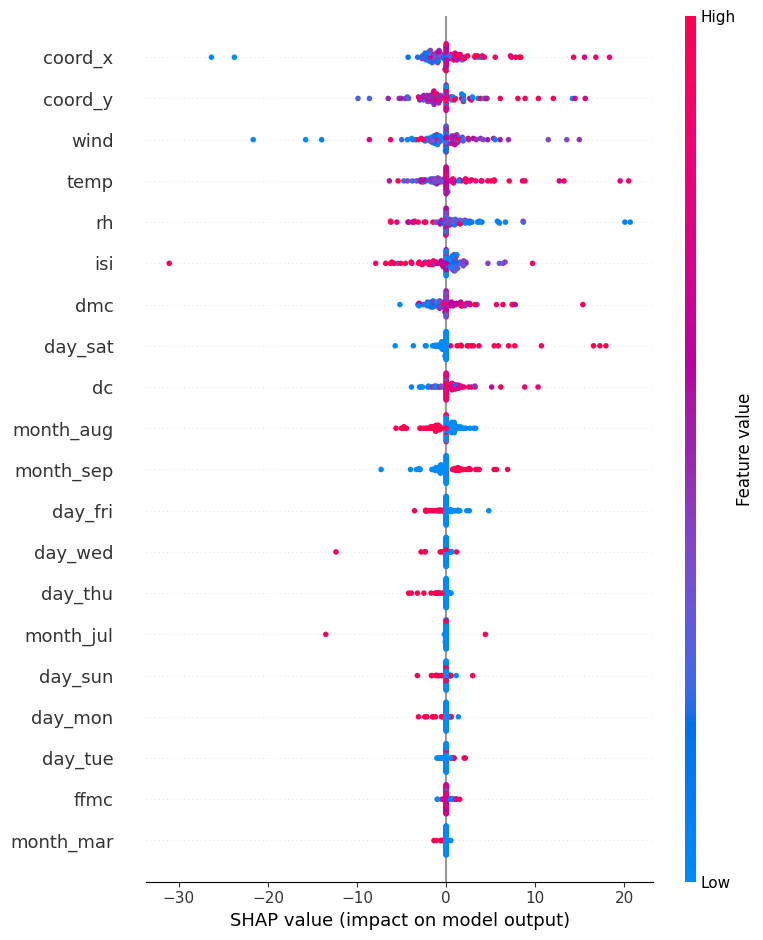

/usr/local/python/3.12.1/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1033: UserWarning: Not enough data in bin #0 for feature wind, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1033: UserWarning: Not enough data in bin #1 for feature wind, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1033: UserWarning: Not enough data in bin #17 for feature wind, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1033: UserWarning: Not enough data in bin #19 for feature wind, so it'll be ignored. Try increasing the number of records to plot.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1033: UserWarning: N

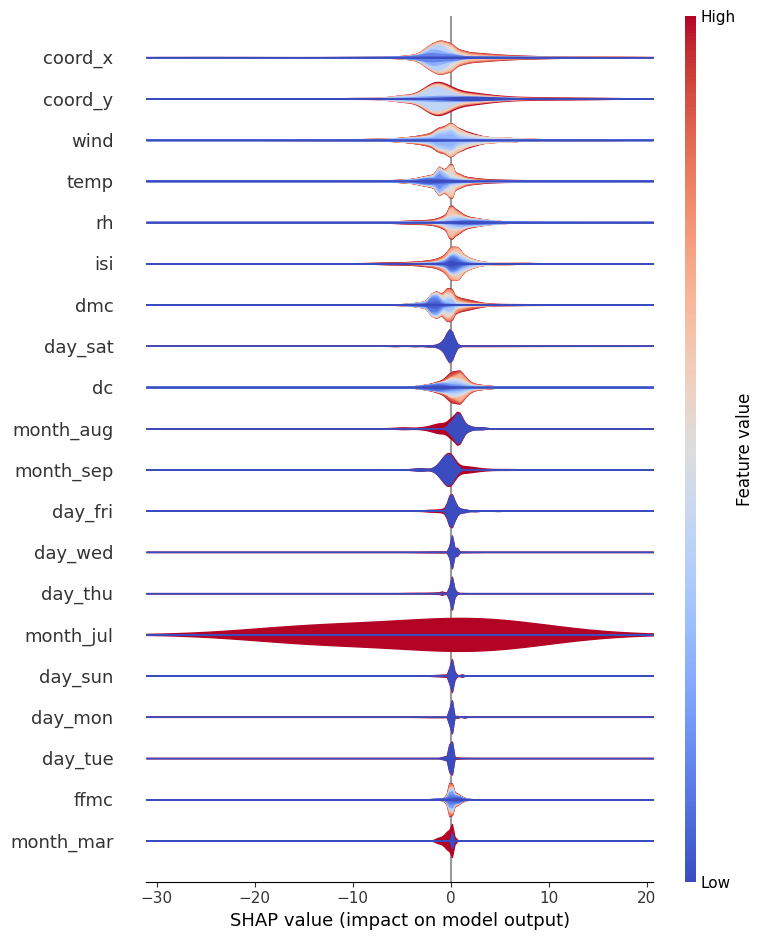

In [56]:
# Visualize the global explanation (summary plot)
shap.summary_plot(shap_values, X_test_processed, feature_names=processed_feature_names)

# Visualize the global explanation (beeswarm plot)
shap.summary_plot(shap_values, X_test_processed, feature_names=processed_feature_names, plot_type="layered_violin")

# feature importance values
shap_importance = pd.DataFrame(list(zip(processed_feature_names, np.abs(shap_values).mean(0))),
                                 columns=['Feature', 'SHAP_Importance'])
shap_importance = shap_importance.sort_values(by='SHAP_Importance', ascending=False)

*(Answer here.)*


Based on the global SHAP summary plots above, we can identify features that contribute the most and least to the model's predictions.

Looking at the mean absolute SHAP values, the most important features appear to be:
- temp which drivs predictions higher
- ffmc is a strong predictor that influences fire behaviour
- isi(Initial spread index)

The features with the lowest impact on the model's output seem to be:
- rain has minimal influence with mostly nearly zero SHAP values
- coord_x and coord_y also show low importance.

If we were to consider removing features from the model, based on this SHAP analysis, we might consider removing rain, coor_x and coord_y becaue of their low SHAP importance and low impact on predictions Removing them could potentially simplify the model, reduce training time, and possibly improve performance.

To test if removing these features would enhance model performance, we would do the following:

1. Create new preprocessors: Modify `preproc1` and `preproc2` or create new versions to exclude the features identified for potential removal.
2. Create new pipelines: Create new pipelines using the modified preprocessors and the same regressors as before.
3. Retune the new pipelines: Perform Grid Search again on these new pipelines using the same cross-validation strategy and parameter grids.
4. Compare performance: Compare the best cross-validation scores of the new pipelines to the best scores of the original pipelines. If the new pipelines achieve a higher negative MSE score, closer to zero, it would suggest that removing those features was beneficial for performance.
5. Final Model Selection based on this comparison: Select the overall best-performing pipeline, whether it is from the original ones or one of the new ones.



## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.